<a href="https://colab.research.google.com/github/chiragmishra03/Thermal_Detection_Using_Yolo/blob/main/Human_Detection_In_Thermal_Images_YOLONAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imutils
!pip install pytube --upgrade
!pip install super-gradients

In [ ]:
import os
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train , coco_detection_yolo_format_val
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models

In [3]:
CHECKPOINT_DIR = 'checkpoints2';
trainer = Trainer(experiment_name = 'human_in_thermal_run2' , ckpt_root_dir = CHECKPOINT_DIR)

In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="8alt1kWsWIlo930A0quA")
project = rf.workspace("chirag-otenn").project("human-detection-in-thermal")
version = project.version(1)
dataset = version.download("yolov5")

In [5]:
dataset_params = {
    'data_dir':'/content/Human-Detection-in-Thermal-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes':['Human']
}

In [9]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': str(dataset_params['data_dir']),
        'images_dir': str(dataset_params['train_images_dir']),
        'labels_dir': str(dataset_params['train_labels_dir']),
        'classes': str(dataset_params['classes']),
    },
    dataloader_params={
        'batch_size': 16,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()


In [ ]:
test_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_s', num_classes=len(dataset_params['classes']),
                   pretrained_weights = "coco"
                   )

In [11]:
train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [13]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-03-02 08:58:00] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240302_085800_340801`
[2024-03-02 08:58:00] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/human_in_thermal_run2/RUN_20240302_085800_340801
[2024-03-02 08:58:00] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints2/human_in_thermal_run2/RUN_20240302_085800_340801/console_Mar02_08_58_00.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
[2024-03-02 08:58:07] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1824       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         114     

In [16]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints2/human_in_thermal_run2/RUN_20240302_085800_340801/ckpt_best.pth")

In [17]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 5/5 [00:03<00:00,  2.01it/s]

{'PPYoloELoss/loss_cls': 0.9295879,
 'PPYoloELoss/loss_iou': 0.54526895,
 'PPYoloELoss/loss_dfl': 0.48728856,
 'PPYoloELoss/loss': 1.9621456,
 'Precision@0.50': 0.03521028533577919,
 'Recall@0.50': 0.9545454382896423,
 'mAP@0.50': 0.7716643810272217,
 'F1@0.50': 0.06791538000106812,
 'Best_score_threshold': 0.4699999988079071}

Testing: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


[2024-03-02 09:29:50] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


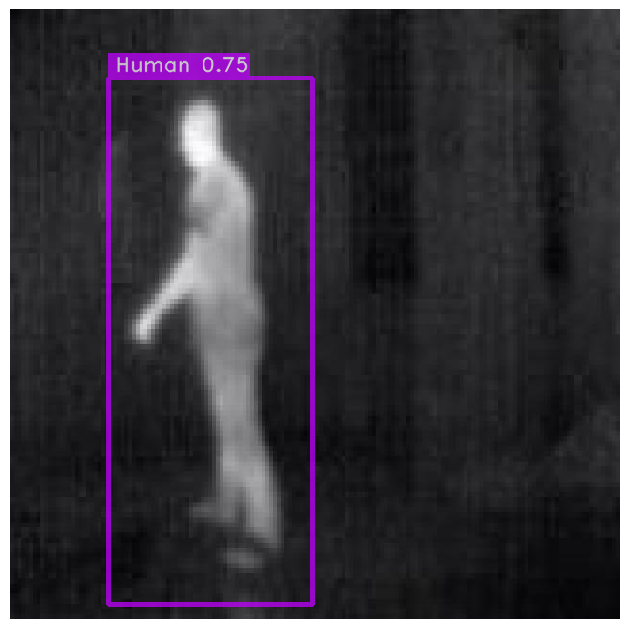

In [19]:
img_url = '/content/Human-Detection-in-Thermal-1/test/images/3_103_jpeg.rf.e616baaa5016cacafb5c86db8bcc814e.jpg'
best_model.predict(img_url).show()

In [25]:
input_video = f"/content/Anonymous Passersby On European Street Scanning Stock Footage Video (100% Royalty-free) 1067128870 _ Shutterstock - Google Chrome 2024-03-02 15-10-14.mp4"
output_video = "detection1.mp4"




In [26]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [27]:
best_model.to(device).predict(input_video).save(output_video)

Processing Video:  99%|█████████▉| 390/393 [00:26<00:00, 17.97it/s]

In [28]:
from IPython.display import HTML
from base64 import b64encode
import os
save_path = '/content/detection1.mp4'
compressed_path = "/content/result_compressed.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""

<video width=400 controls>
  <source src="%s" type="video/mp4">
  </video>

""" % data_url)